# Classification on MNIST

## Data Prepration
first thing to do, we downlaod the mnist dataset from sklearn datasets. We also need to know what kind of data we are dealing with and answer questions like how many samples do we have, what is the shape of each sample , etc.

In [8]:
from sklearn.datasets.base import get_data_home 
print (get_data_home())

/home/aramhamidi/scikit_learn_data


In [9]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [12]:
mnist     

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

As we can see in the description, data is containing one row per instance and one column per feature.

In [13]:
x,y = mnist['data'],mnist['target']
print(x.shape)
print(y.shape)

(70000, 784)
(70000,)


number of images are 70000 and we have 784 features per sample. 784 is coming from the fact that images are 28 by 28 pixels and each pixel counts as a feature. Now let's look at some of those sample images.

In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

label of this image is  3.0


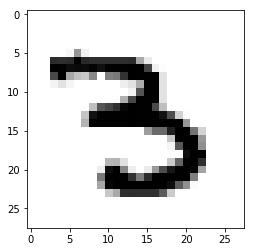

In [35]:
picked_sample = x[22000]
picked_sample_image = picked_sample.reshape(28,28)
print('label of this image is ',y[22000])
plt.imshow(picked_sample_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.show()

### Train, Test and Validation sets
mnist dataset is already splited in to training set, which is the first 60000 images, and also test set whih is the last 10000 images. However we need to shuffle the training set to garantee that our training dataset is random enough.

In [36]:
x_train, y_train, x_test, y_test = x[:60000], y[:60000], x[60000:], y[60000:]

In [37]:
import numpy as np
shuffle_index = np.random.permutation(60000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier
This is the first classifier, we are going to explor. Binary classifier in this case can detec one digit among the others. It acts like a Buzzer, whenever it finds a *'3'* for example, it Buzzez that it found one. Of course if it trains well. Otherwise it won't be able to find any.

In [38]:
# In our binary classifier we only care about two kind of labels: 1 (for digits == 3 and 0 (for digits != 3)
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3) 

Since our dataset is fairly large, let's use SGD classierfier. SGD classifiers are also very efficient for online training.

In [39]:
from sklearn.linear_model import SGDClassifier
# since we want some reproducable results, we set the random_state parameter
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_3)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [40]:
sgd_clf.predict([picked_sample])

array([ True], dtype=bool)

That sweet "True" up here means that our classifier thinks out picked_sample is a 3, which is correct! But we can't get too excited too early. Let's see how is the actuall performance of our classifier. We have so many different performance measures to work with such as:
1.Measuring accuracy with Cross-Validation
2.Confusion Matrix
3.

### Measuring Accuracy with Cross-Validation
There are many different ways to do cross-validation. Here we will a K-fold cross-validation, meaning to split the training set into K folds, then chose one fold to evaluate the trained model on other folds.

In [41]:
from sklearn.model_selection import cross_val_score
# we pick 3 folds
folds_validation = cross_val_score(sgd_clf, x_train, y_train_3, cv=3, scoring='accuracy')
print(folds_validation)

[ 0.9680016  0.96225    0.9640482]


Shall we now get excited? Let's see how a simple classifier does on the images that are not 3.

In [44]:
from sklearn.base import BaseEstimator
class notA3Classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self, x):
        return np.zeros((len(x),1 ), dtype=bool)

not3_clf = notA3Classifier()
cross_val_score(not3_clf, x_train, y_train, cv=3, scoring='accuracy')

array([ 0.09875,  0.0984 ,  0.099  ])

Then the answer is no, dont get too exited. It also makes sence sice only 10% of the data is '3'. So even if this classifier always predicts that the data is not a '3' it is correct 90% of the times!

#### Conclusion
Accuracy is not always the best metric to measure the performance. Specially when we are dealing with skewed datasets.

### Confusion Matix
The idea is to see how many times a sample of class A has been classified as class B (meaning classifier got confused!). In this case you can look at the row A and column B of the confusion matrix.
We need predictions, but not on test set, cause we want to keep it untouched for now.

In [46]:
from sklearn.model_selection import cross_val_predict
#cross_val_predict performs similar to cross_val_score but returns predictions instead of evaluation scores.
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_3, cv=3)

Notice that sgd_clf is not trained on the same dataset.(y_train_3 not y_train). So the predictions here are clean.

In [49]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_train_3, y_train_pred)
CM

array([[52971,   898],
       [ 1216,  4915]])

First row is for *negative class* or *not-3* digits and the second or is for *positive class*.
So as you can see, the classifier has been wrongly classifying non 3 digits as 3, 898 times and also 3 digits as not-3, 1216 times. So we can say:

  FN(True Positive) = 1216
  
  TN(True Negative) = 52971

  FP(False Positive) = 898

  TP(False Negative) = 4915

In [54]:
classifier_precision = CM[1][1] / (CM[1][1]  + CM[0][1])  
print('pricision of classifier:', classifier_precision)

pricision of classifier: 0.845518665061


In [55]:
classifier_recall = CM[1][1] / (CM[1][1]  + CM[1][0])  
print('sensitivity, or recall of classifier:', classifier_recall)

sensitivity, or recall of classifier: 0.801663676399


In [60]:
# We can se sklearn to calculate these metrics as well
from sklearn.metrics import recall_score, precision_score, f1_score
print('precision with skearn:',precision_score(y_train_3, y_train_pred))
print('recall with sklearn', recall_score(y_train_3, y_train_pred))
print('F1-score of classifier', f1_score(y_train_3, y_train_pred))

precision with skearn: 0.845518665061
recall with sklearn 0.801663676399
F1-score of classifier 0.823007367716


So our classifier precision in detecting 3-digit is only 84% and it can detect digit-3 only 80% of the times. Not very impressive to get excited about. And F1 score is high only when both presicion and sensitivity are high.